In [1]:
cd ..


/Users/mushahid/Desktop/ProjectFInal/UnsupGenModbyMPS


In [2]:
%load_ext autoreload

import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
import jax.numpy as jnp
import optax
import jax
import mps_circuit_helpers
import mps_circuit
import metrics

from tqdm import tqdm
from jax.config import config
config.update("jax_enable_x64", True)
from MPScumulant import MPS_c


In [ ]:
wires = 12
dev = qml.device("default.qubit", wires=wires)
weights = jnp.array(pnp.random.normal(size=(88, 15), requires_grad=True))

@qml.qnode(dev, interface="jax")
def random_initialized_circuit(weights, sample=None):
    i = 0
    while i < 11:
        qml.SpecialUnitary(weights[i], wires=[i, i + 1])
        i += 1
    w = 0
    while i < 22:
        qml.SpecialUnitary(weights[i], wires=[w, w + 1])
        w += 1
        i += 1    
    
    for x in range(wires - 1):
        for j in range(x + 1, wires):
            qml.SpecialUnitary(weights[i], wires=[x, j])
            i += 1
    if sample:
        return qml.sample()
    return qml.probs(wires=list(range(wires)))

@jax.jit
def loss(weights):
    probs = random_initialized_circuit(weights)
    return metrics.kl_divergence_synergy_paper(2 ** 12, probs)

N_ITS = 10000

loss_track = []
opt_exc = optax.adam(0.01)
opt_state = opt_exc.init(weights)

loss_track.append(loss(weights))

for it in tqdm(range(N_ITS)):
    grads = jax.grad(loss)(weights)
    updates, opt_state = opt_exc.update(grads, opt_state)

    weights = optax.apply_updates(weights, updates)
    loss_track.append(loss(weights))

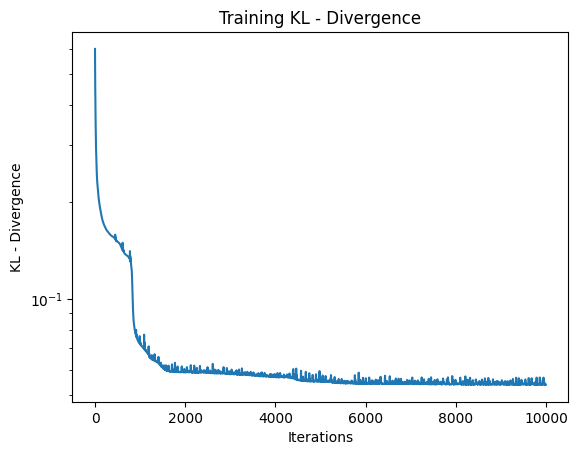

In [10]:
plt.plot(loss_track)
plt.title('Training KL - Divergence')
plt.xlabel('Iterations')
plt.ylabel('KL - Divergence')
plt.yscale('log')